## Drug-Prescription-Model
The model finds out the most useful drugs for a particular conditions by analyzing the reviews, ratings  and effectiveness of the drugs in each scenario. 

#### IMPORTING ALL THE NECESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets
from ipywidgets import interact
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sahil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### READING THE DATA

In [2]:
data = pd.read_csv('drug.csv')
# printing the shape of the dataset
print("The Shape of the Dataset :", data.shape)

The Shape of the Dataset : (161297, 7)


In [4]:
# printing the head of the dataset
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [5]:
# lets summarize Categorical data also
data[['drugName','condition','review']].describe(include = 'object')

,drugName,condition,review
count,161297,160398,161297
unique,3436,884,112329
top,Levonorgestrel,Birth Control,"""Good"""
freq,3657,28788,33


In [6]:
# lets check for Missing Values
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [7]:
# as we know that 'condition' is an Important Column, so we will delete all the records where Condition is Missing
data = data.dropna()
# lets check the Missing values now
data.isnull().sum().sum()

0

#### UNDERSTANDING THE IMPACT OF DATA

In [8]:
# Checking whether Length of Review has any Impact on Ratings of the Drugs
data['len'] = data['review'].apply(len)
# lets check the Highest Length Review
print("Length of Longest Review", data['len'].max())
data['review'][data['len'] == data['len'].max()].iloc[0]

Length of Longest Review 10787


'"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conversational vo

#### DATA CLEANING (REVIEWS)

In [9]:
# First lets remove Punctuations from the Reviews

def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

data['review'] = data['review'].apply(punctuation_removal)

In [10]:
# Now lets Remove the Stopwords also
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop:
    new_item = punctuation_removal(item)
    stop_words.append(new_item)

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str
            if word.lower() not in stop_words ]

data['review'] = data['review'].apply(stopwords_removal)


In [11]:
# lets remove the Numbers
import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

data['review'] = data['review'].apply(drop_numbers)

In [12]:
print(data['review'])

0         side effect take combination bystolic mg fish oil
1         son halfway fourth week intuniv became concern...
2         used take another oral contraceptive pill cycl...
3         first time using form birth control glad went ...
4         suboxone completely turned life around feel he...
                                ...                        
161292    wrote first report midoctober alcohol since po...
161293    given iv surgey immediately became anxious cou...
161294    limited improvement months developed bad rash ...
161295    thyroid medication years spent first synthroid...
161296    chronic constipation adult life tried linzess ...
Name: review, Length: 160398, dtype: object


#### CALCULATE SENTIMENT FOR REVIEWS

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
train_sentiments = []
for i in data['review']:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
train_sentiments = np.asarray(train_sentiments)
data['sentiment'] = pd.Series(data=train_sentiments)

In [14]:
# lets remove the unique Id, date, review, len, and sentiment column also
data = data.drop(['date','uniqueID','sentiment','review','len'], axis = 1)
# columns available now
data.columns

Index(['drugName', 'condition', 'rating', 'usefulCount'], dtype='object')

#### CALCULATING EFFECTIVENESS AND USEFULNESS OF DRUGS

In [15]:
min_rating = data['rating'].min()
max_rating = data['rating'].max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating / (max_rating - 1)
    rating *= 5
    rating = int(round(rating, 0))

    if (int(rating) == 0 or int(rating) == 1 or int(rating) == 2):
        return 0
    else:
        return 1

data['eff_score'] = data['rating'].apply(scale_rating)

In [16]:
# lets also calculate Usefulness Score
data['usefulness'] = data['rating']*data['usefulCount']*data['eff_score']

In [17]:
# lets check the Top 10 Most Useful Drugs with their Respective Conditions
data[['drugName','condition','usefulness']][data['usefulness'] > data['usefulness'].mean()].sort_values(by = 'usefulness',ascending = False).head(10).reset_index(drop = True)

,drugName,condition,usefulness
0,Sertraline,Depression,12910
1,Zoloft,Depression,12910
2,Levonorgestrel,Birth Control,12470
3,Mirena,Birth Control,12470
4,Zoloft,Depression,8541
5,Phentermine,Weight Loss,7960
6,Adipex-P,Weight Loss,7960
7,Implanon,Birth Control,7300
8,Viibryd,Depression,6930
9,Vilazodone,Depression,6930


#### ANALYZING THE MEDICAL CONDITIONS

In [18]:
# lets calculate the Number of Useless and Useful Drugs for Each Condition
@interact
def check(condition = list(data['condition'].value_counts().index)):
    return data[data['condition'] == condition]['eff_score'].value_counts()

interactive(children=(Dropdown(description='condition', options=('Birth Control', 'Depression', 'Pain', 'Anxie…

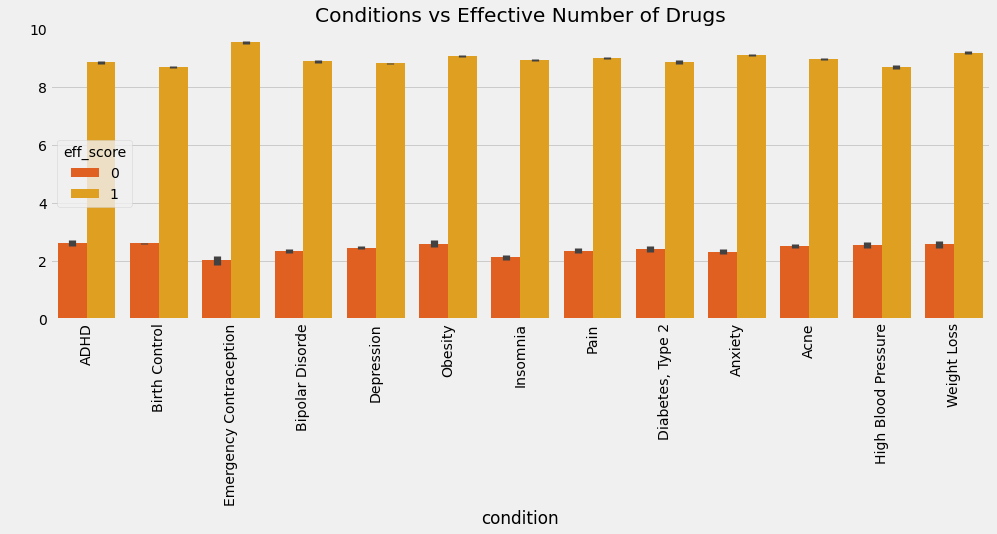

In [19]:
# Graphically How it looks,
popular_conditions = ('Birth Control','Depression','Pain','Anxiety','Acne','Bipolar Disorde','Insomnia','Weight Loss', 'Obesity','ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure','Migrane')
conditions = data.loc[data['condition'].isin(popular_conditions)]
sns.barplot(x = conditions['condition'], y = conditions['rating'], hue = data['eff_score'],palette = 'autumn')
plt.title('Conditions vs Effective Number of Drugs')
plt.xticks(rotation = 90)
plt.ylabel(' ')
plt.show()

In [20]:
# Most Common Conditions
print("Number of Unique Conditions :", data['condition'].nunique())
data['condition'].value_counts().head(10)
# lets check Drugs, which were useful to Highest Number of Poeple
data[['drugName','usefulCount']][data['usefulCount'] > data['usefulCount'].mean()].sort_values(by = 'usefulCount',ascending = False).head(10).reset_index(drop = True)

Number of Unique Conditions : 884


,drugName,usefulCount
0,Zoloft,1291
1,Sertraline,1291
2,Levonorgestrel,1247
3,Mirena,1247
4,Zoloft,949
5,Adipex-P,796
6,Phentermine,796
7,Celexa,771
8,Citalopram,771
9,Implanon,730


#### FINDING OUT THE MOST USEFUL DRUG AND USELESS DRUG

In [22]:
# remove all the Duplicate elements from the Dataset
data = data.drop_duplicates()

In [23]:
@interact
def high_low_rate(condition = list(data['condition'].value_counts().index)):
    print("\n Top 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness', ascending = False).head().reset_index(drop = True))
    print("\n\n Bottom 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness', ascending = True).head().reset_index(drop = True))

interactive(children=(Dropdown(description='condition', options=('Birth Control', 'Depression', 'Pain', 'Anxie…